### Library Import

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append("..")

from src.sanity import *

In [2]:
np.random.seed(80)
plt.style.use("seaborn-v0_8-darkgrid")
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

%config InlineBackend.figure_format = 'retina'

### Load dataset 

In [4]:
from src.load_datasets import load_air_polution_data

dataframe = (
    load_air_polution_data()
    .pipe(format_datetime, col="Date_Time")
    .pipe(set_index, col="Date_Time")
    .pipe(interpolate_column, cols="pollution")
    .pipe(resample_data, freq="H")
)

print(f"dataframe shape {dataframe.shape}")

# dataframe = dataframe.tail(515)

dataframe.head()

format_datetime: DF Shape (43800, 9)
set_index: DF Shape (43800, 8)
interpolate_columns: DF Shape (43800, 8)
resample_Data: DF Shape (43800, 7)
dataframe shape (43800, 7)


,pollution,dewp,temp,press,wnd_spd,snow,rain
Date_Time,,,,,,,
2010-01-02 00:00:00,129.0,-16.0,-4.0,1020.0,1.79,0.0,0.0
2010-01-02 01:00:00,148.0,-15.0,-4.0,1020.0,2.68,0.0,0.0
2010-01-02 02:00:00,159.0,-11.0,-5.0,1021.0,3.57,0.0,0.0
2010-01-02 03:00:00,181.0,-7.0,-5.0,1022.0,5.36,1.0,0.0
2010-01-02 04:00:00,138.0,-7.0,-5.0,1022.0,6.25,2.0,0.0


In [5]:
# dataframe.info()
# dataframe.isna().sum()
corr = dataframe.corr()
corr.style.background_gradient(cmap="coolwarm")

,pollution,dewp,temp,press,wnd_spd,snow,rain
pollution,1.000000,0.157731,-0.099956,-0.035189,-0.242691,0.018864,-0.052134
dewp,0.157731,1.000000,0.824432,-0.778737,-0.296720,-0.034484,0.125053
temp,-0.099956,0.824432,1.000000,-0.827205,-0.154902,-0.092726,0.049037
press,-0.035189,-0.778737,-0.827205,1.000000,0.185380,0.069031,-0.079840
wnd_spd,-0.242691,-0.296720,-0.154902,0.185380,1.000000,0.021876,-0.010137
snow,0.018864,-0.034484,-0.092726,0.069031,0.021876,1.000000,-0.009553
rain,-0.052134,0.125053,0.049037,-0.079840,-0.010137,-0.009553,1.000000


### Test Train split

train_xy and test_xy size: (43785, 7), (15, 7)

y_train and x_train size (43785,), (43785, 6)
y_test  and x_test  size (15,),  (15, 6)



(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='pollution'>)

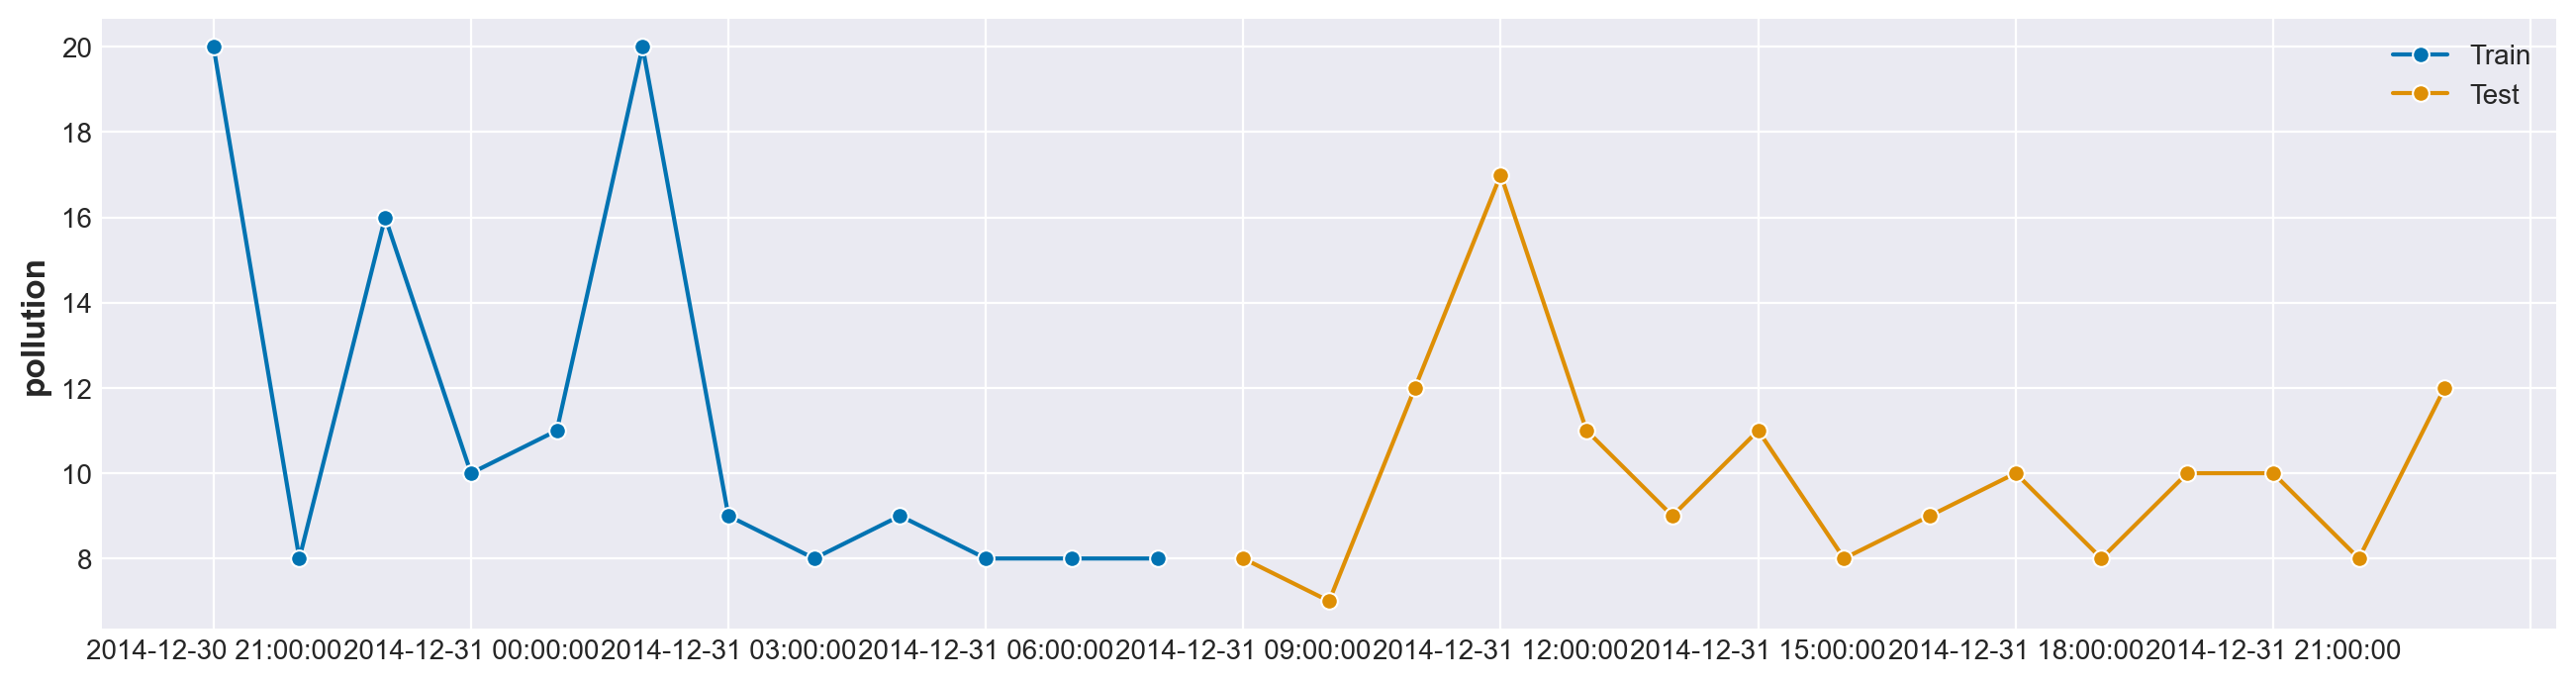

In [6]:
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split

TEST_SIZE = 15
TARGET_COl = "pollution"

train_xy, test_xy = temporal_train_test_split(dataframe, test_size=TEST_SIZE)

print(f"train_xy and test_xy size: {train_xy.shape}, {test_xy.shape}", end="\n\n")

y_train = train_xy[TARGET_COl].copy(deep=True)
x_train = train_xy.drop(columns=[TARGET_COl]).copy(deep=True)

y_test = test_xy[TARGET_COl].copy(deep=True)
x_test = test_xy.drop(columns=[TARGET_COl]).copy(deep=True)

print(f"y_train and x_train size {y_train.shape}, {x_train.shape}")
print(
    f"y_test  and x_test  size {y_test.shape},  {x_test.shape}",
    end="\n\n",
)

plot_series(y_train.tail(12), y_test, labels=["Train", "Test"])

#### Huyper Parameter Selection 

intital_window_size 43710 , step_length 15 for fold 5


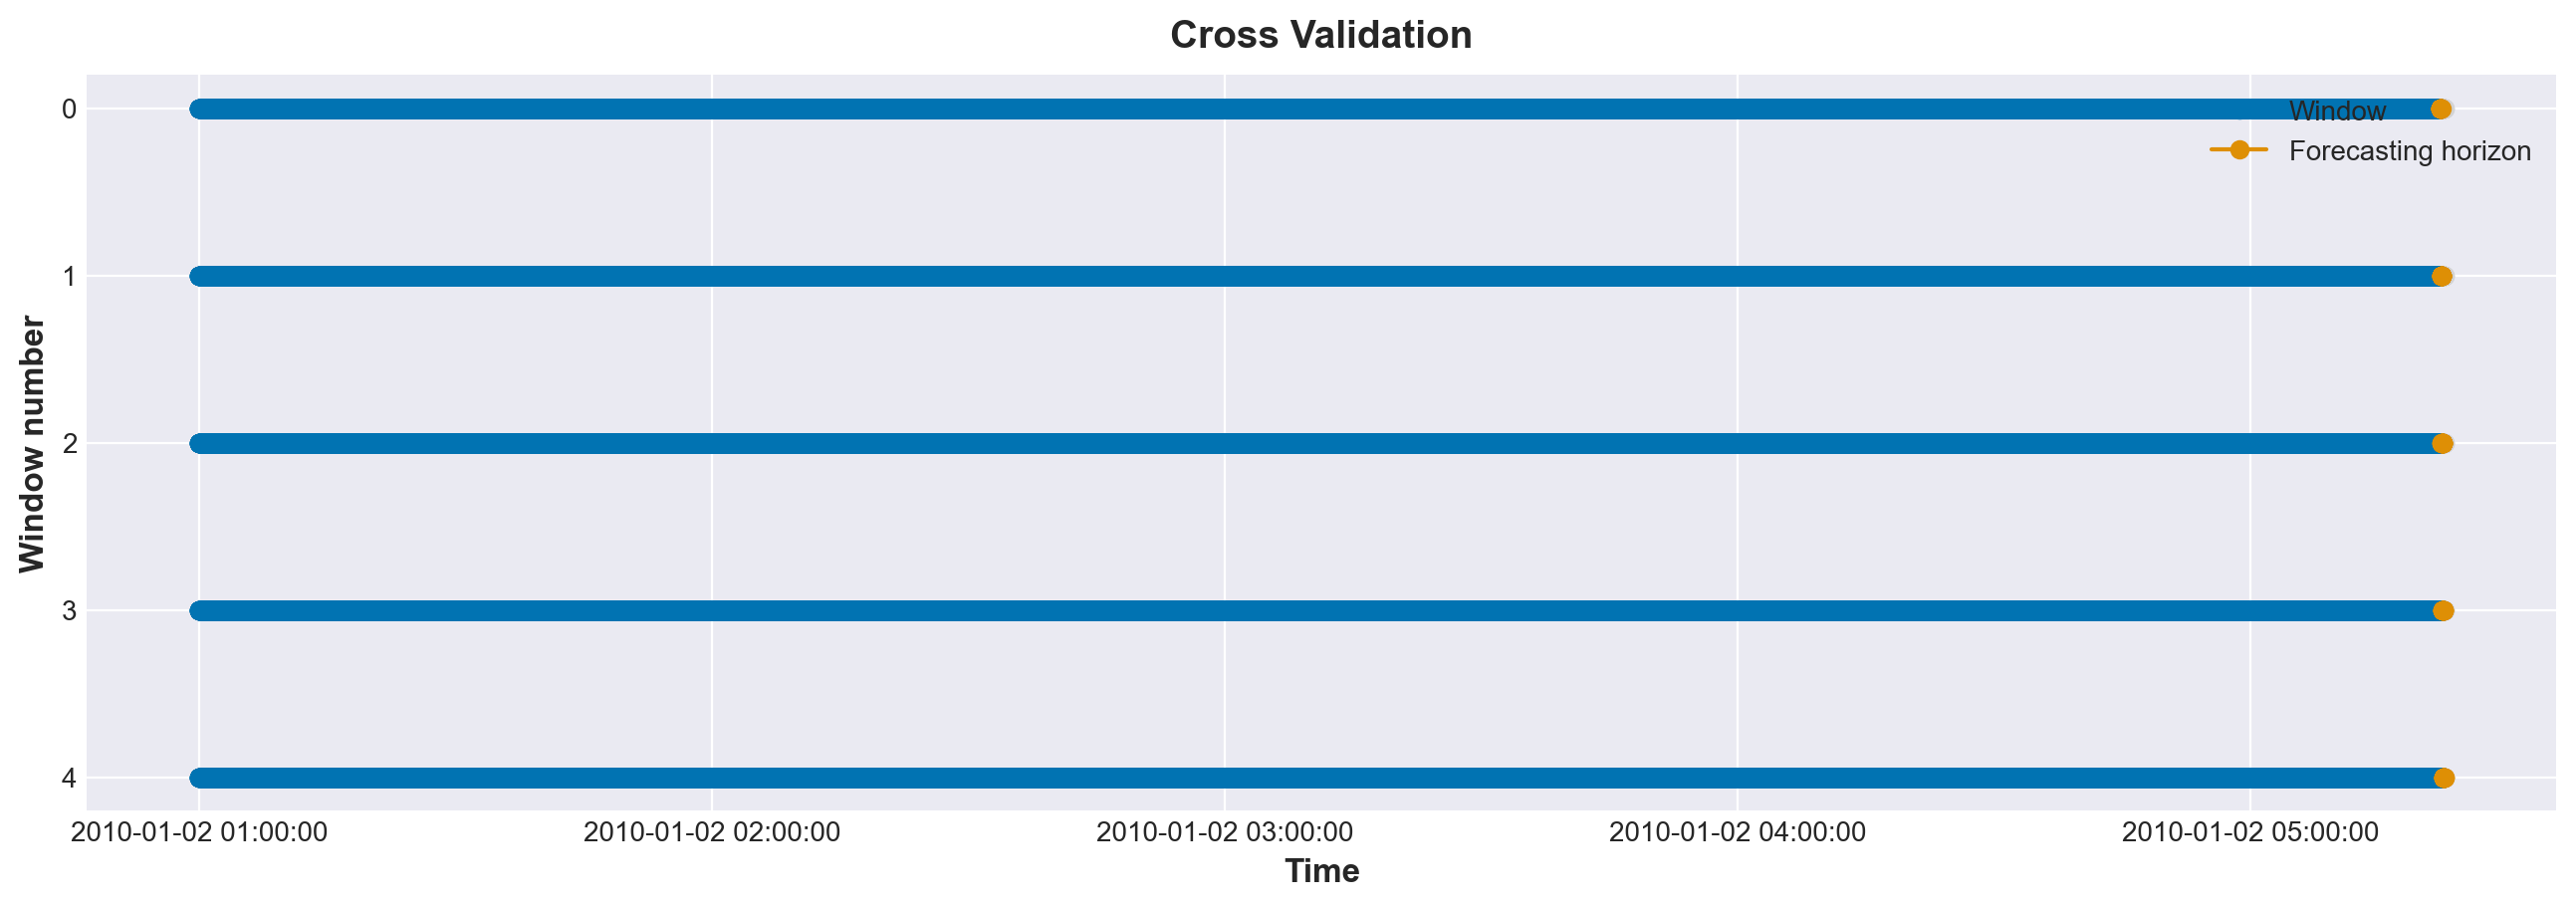

In [7]:
from sktime.forecasting.model_selection import (
    ExpandingWindowSplitter,
    SlidingWindowSplitter,
)
from sktime.utils.plotting import plot_windows

fh = np.arange(1, TEST_SIZE + 1)

y_size = len(y_train)

fold = 5

step_length = len(fh)

fh_max_length = max(fh)

intital_window_size = y_size - ((fold - 1) * step_length + 1 * fh_max_length)

# intital_window_size = int(y_train.shape[0] * 0.80)

print(
    f"intital_window_size {intital_window_size} , step_length {step_length} for fold {fold}"
)

cv = ExpandingWindowSplitter(
    fh, initial_window=intital_window_size, step_length=step_length
)

plot_windows(cv, y_train, title="Cross Validation")

In [9]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

from sktime.forecasting.compose import (
    ForecastingPipeline,
    make_reduction,
    TransformedTargetForecaster,
)
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sktime.transformations.compose import TransformerPipeline
from sktime.transformations.series.impute import Imputer
from sktime.transformations.series.detrend import (
    Detrender,
    Deseasonalizer,
    ConditionalDeseasonalizer,
)
from sktime.forecasting.trend import PolynomialTrendForecaster

from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

param_grid = {
    "forecaster__deseasonalizer__model": ["additive"],
    "forecaster__deseasonalizer__sp": [24, 48],
    "forecaster__detrender__forecaster__degree": [1, 2],
    "forecaster__reducer__window_length": [10],
    "forecaster__reducer__estimator__fit_intercept": [True, False],
}

forecaster_pipe = ForecastingPipeline(
    steps=[
        (
            "x_transforner",
            TransformerPipeline(
                steps=[("imputer_x", Imputer(method="ffill", random_state=80))]
            ),
        ),
        ("scaler_x", TabularToSeriesAdaptor(MinMaxScaler())),
        (
            "forecaster",
            TransformedTargetForecaster(
                steps=[
                    ("imputer_y", Imputer(method="ffill", random_state=80)),
                    (
                        "deseasonalizer",
                        ConditionalDeseasonalizer(model="additive", sp=24),
                    ),
                    (
                        "detrender",
                        Detrender(forecaster=PolynomialTrendForecaster(degree=1)),
                    ),
                    (
                        "reducer",
                        make_reduction(
                            estimator=LinearRegression(),
                            scitype="tabular-regressor",
                            window_length=10,
                            strategy="recursive",
                            pooling="global",
                        ),
                    ),
                ]
            ),
        ),
    ]
)

fh = np.arange(1, TEST_SIZE + 1)

cv = ExpandingWindowSplitter(
    fh, initial_window=intital_window_size, step_length=step_length
)

print(f"Number of CPU Count:   {os.cpu_count()}")

n_cpu = os.cpu_count() - 1 if os.cpu_count() > 2 else 1

gscv = ForecastingGridSearchCV(
    forecaster_pipe,
    strategy="refit",
    scoring=MeanAbsolutePercentageError(symmetric=True),
    cv=cv,
    param_grid=param_grid,
    verbose=10,
    n_jobs=n_cpu,
    refit=True,
    error_score="raise",
)

gscv.fit(y_train, X=x_train, fh=fh)

print("Best Params", gscv.best_params_)
print("Best Params", gscv.best_score_)
# print('Best Params', gscv.best_forecaster_)

Number of CPU Count:   12
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Params {'forecaster__deseasonalizer__model': 'additive', 'forecaster__deseasonalizer__sp': 48, 'forecaster__detrender__forecaster__degree': 2, 'forecaster__reducer__estimator__fit_intercept': False, 'forecaster__reducer__window_length': 10}
Best Params 0.7689799102531001


2014-12-31 09:00:00     7.696936
2014-12-31 10:00:00     6.487713
2014-12-31 11:00:00     4.508514
2014-12-31 12:00:00     1.963535
2014-12-31 13:00:00    -1.904687
2014-12-31 14:00:00    -6.410207
2014-12-31 15:00:00    -9.817478
2014-12-31 16:00:00   -10.440708
2014-12-31 17:00:00   -10.469159
2014-12-31 18:00:00    -6.327330
2014-12-31 19:00:00    -1.601683
2014-12-31 20:00:00     4.729972
2014-12-31 21:00:00     8.211187
2014-12-31 22:00:00    10.227800
2014-12-31 23:00:00    10.744825
Freq: H, Name: pollution, dtype: float64

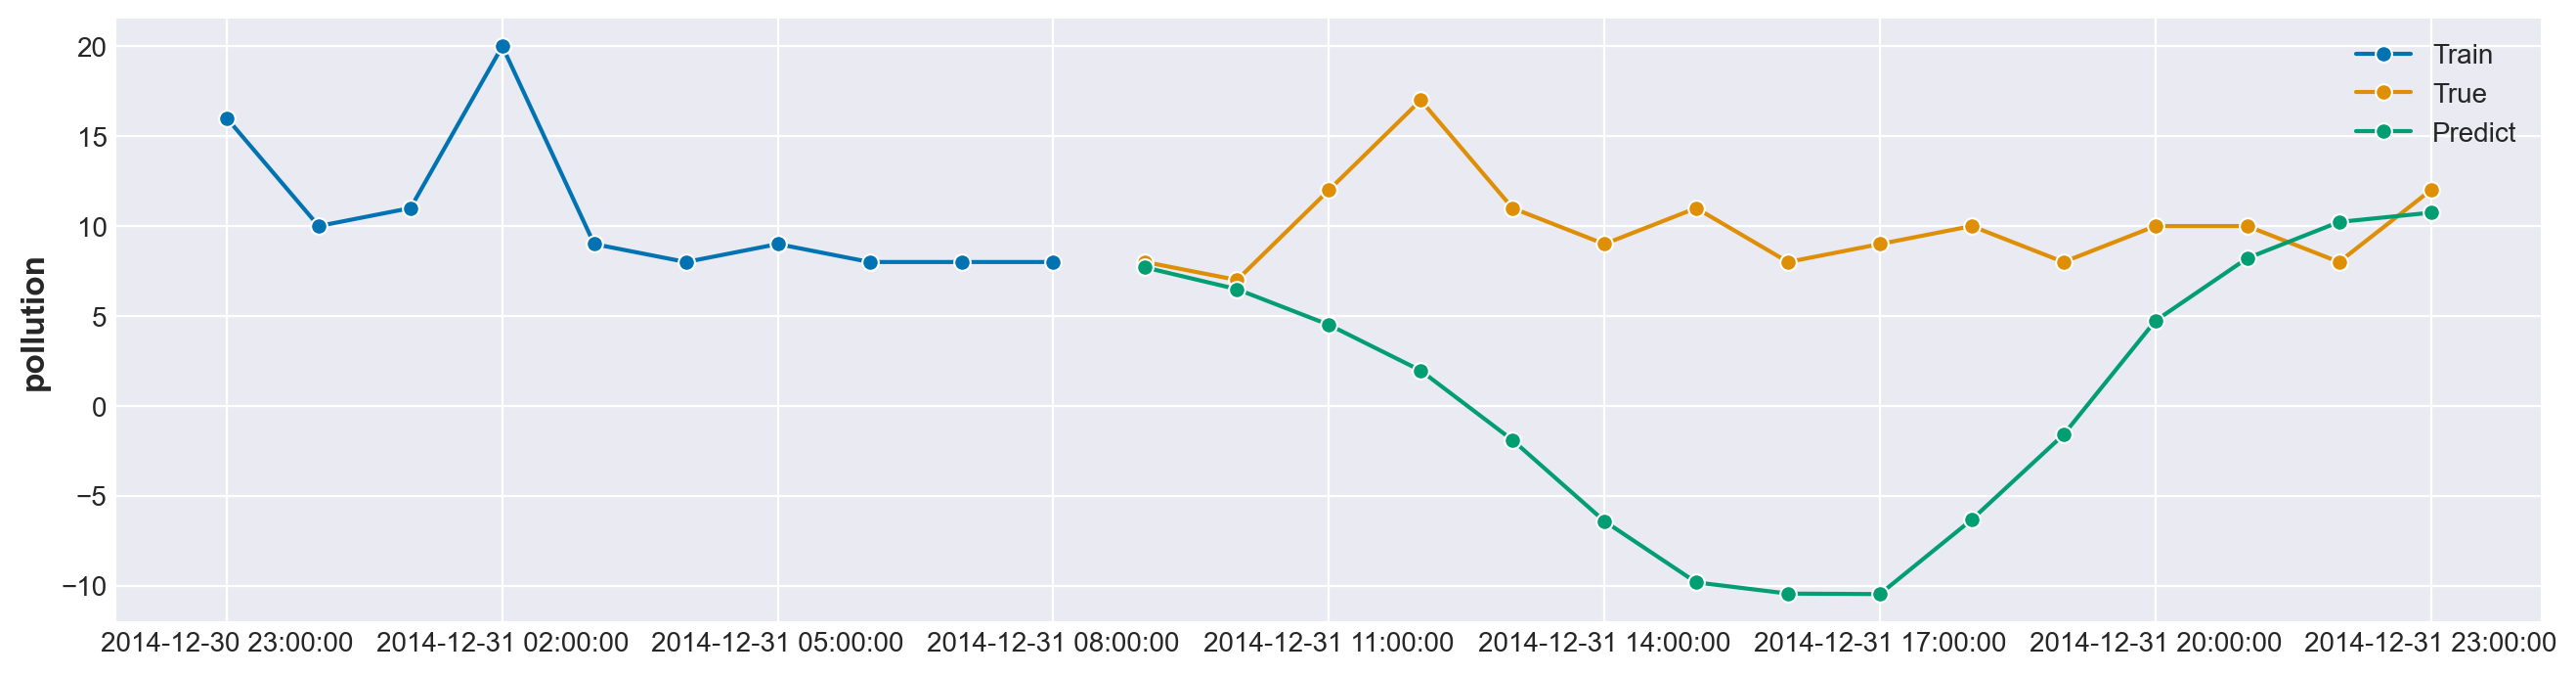

In [10]:
y_predict = gscv.predict(fh=fh, X=x_test)
plot_series(y_train.tail(10), y_test, y_predict, labels=["Train", "True", "Predict"])
y_predict

In [11]:
print(gscv.cv_results_.shape)
gscv.cv_results_.head()

(8, 5)


,mean_test_MeanAbsolutePercentageError,mean_fit_time,mean_pred_time,params,rank_test_MeanAbsolutePercentageError
0,0.781997,0.661902,0.422692,{'forecaster__deseasonalizer__model': 'additiv...,8.0
1,0.774530,0.754605,0.447898,{'forecaster__deseasonalizer__model': 'additiv...,4.0
2,0.777114,0.687471,0.487478,{'forecaster__deseasonalizer__model': 'additiv...,6.0
3,0.769982,0.711991,0.493083,{'forecaster__deseasonalizer__model': 'additiv...,2.0
4,0.780443,0.748307,0.454793,{'forecaster__deseasonalizer__model': 'additiv...,7.0


### Backtesting Insample Prediction

In [13]:
from sktime.forecasting.model_evaluation import evaluate

results = evaluate(
    forecaster=gscv.best_forecaster_,
    y=y_train,
    X=x_train,
    cv=cv,
    scoring=MeanAbsolutePercentageError(symmetric=False),
    return_data=True,
)
results

,test_MeanAbsolutePercentageError,fit_time,pred_time,len_train_window,cutoff,y_train,y_test,y_pred
0,1.947136,3.690462,0.252171,43710,2014-12-28 05:00:00,Date_Time 2010-01-02 00:00:00 129.0 2010-01...,Date_Time 2014-12-28 06:00:00 264.0 2014-12...,2014-12-28 06:00:00 266.454617 2014-12-28 0...
1,0.315166,3.653720,0.260424,43725,2014-12-28 20:00:00,Date_Time 2010-01-02 00:00:00 129.0 2010-01...,Date_Time 2014-12-28 21:00:00 293.0 2014-12...,2014-12-28 21:00:00 185.846730 2014-12-28 2...
2,1.321315,3.582415,0.329960,43740,2014-12-29 11:00:00,Date_Time 2010-01-02 00:00:00 129.0 2010-01...,Date_Time 2014-12-29 12:00:00 56.0 2014-12...,2014-12-29 12:00:00 130.286719 2014-12-29 1...
3,2.347547,3.599184,0.403357,43755,2014-12-30 02:00:00,Date_Time 2010-01-02 00:00:00 129.0 2010-01...,Date_Time 2014-12-30 03:00:00 28.0 2014-12-...,2014-12-30 03:00:00 77.497058 2014-12-30 04...
4,5.156601,3.554285,0.324096,43770,2014-12-30 17:00:00,Date_Time 2010-01-02 00:00:00 129.0 2010-01...,Date_Time 2014-12-30 18:00:00 79.0 2014-12-...,2014-12-30 18:00:00 66.371941 2014-12-30 19...


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='pollution'>)

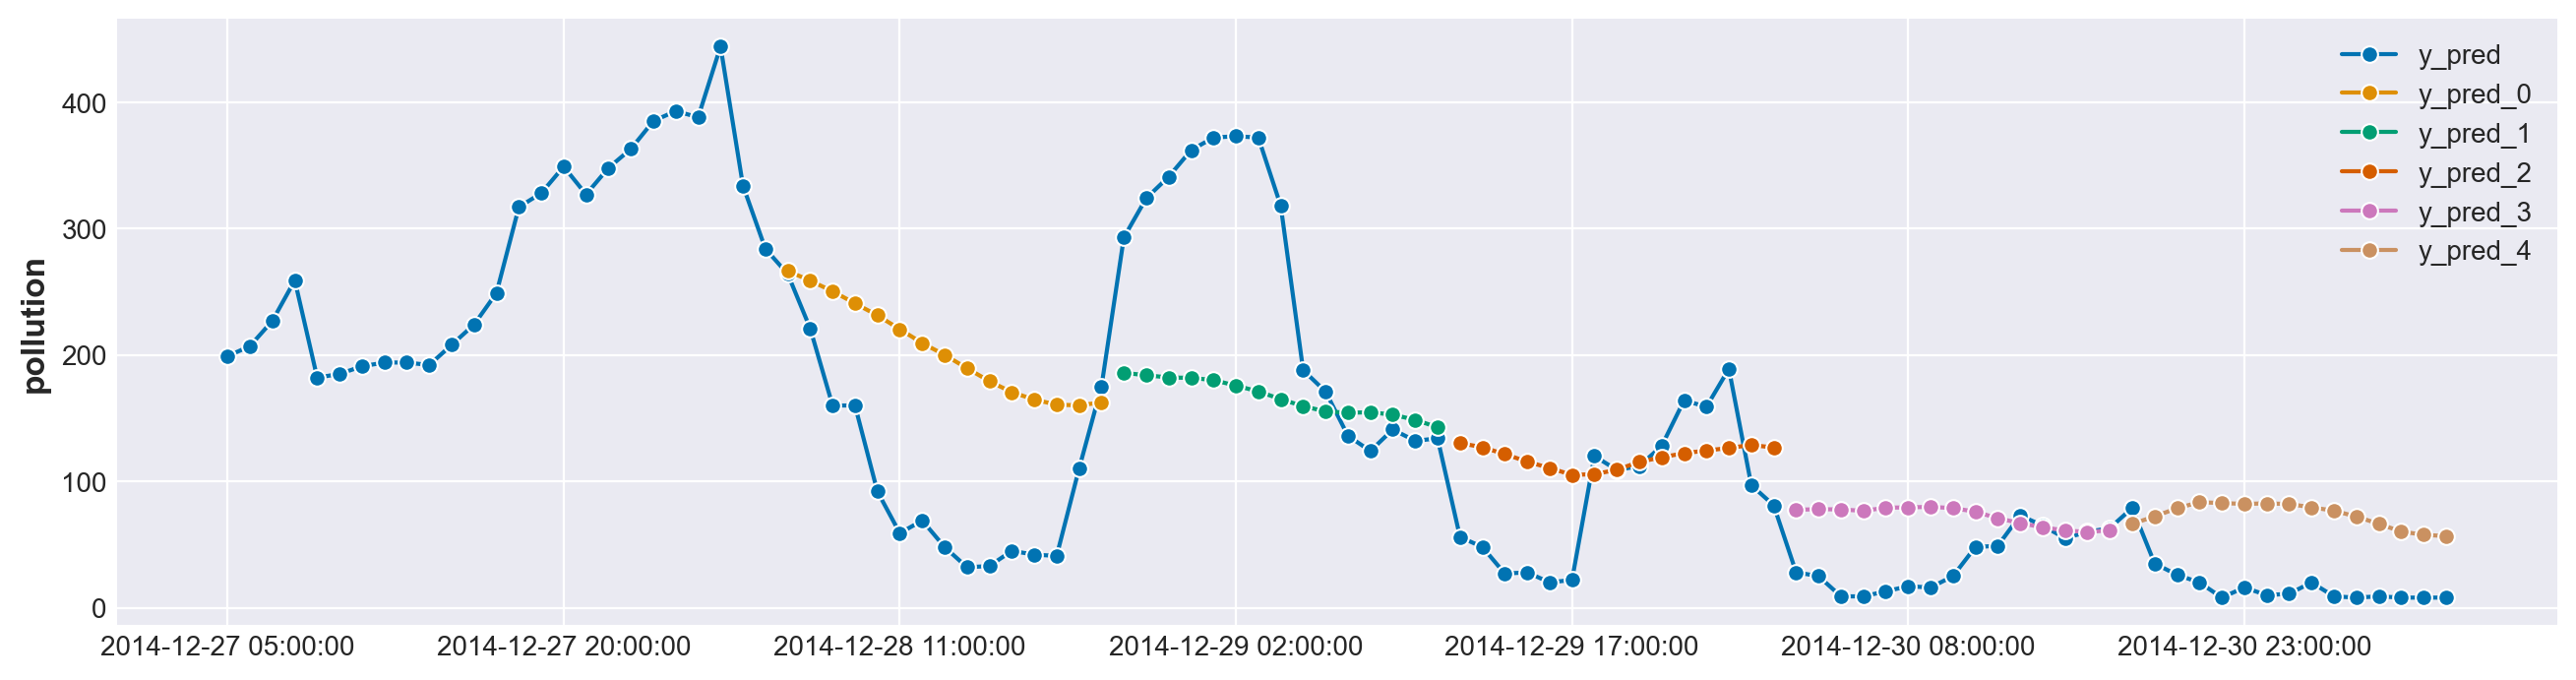

In [14]:
plot_series(
    y_train.tail(100),
    *results["y_pred"].to_list(),
    labels=["y_pred"] + [f"y_pred_{i}" for i in results.index],
)

### Get best model Parameters

In [15]:
gscv.best_forecaster_.get_fitted_params()

{'forecaster': TransformedTargetForecaster(steps=[('imputer_y',
                                     Imputer(method='ffill', random_state=80)),
                                    ('deseasonalizer',
                                     ConditionalDeseasonalizer(sp=48)),
                                    ('detrender',
                                     Detrender(forecaster=PolynomialTrendForecaster(degree=2))),
                                    ('reducer',
                                     RecursiveTabularRegressionForecaster(estimator=LinearRegression(fit_intercept=False),
                                                                          pooling='global'))]),
 'steps': [('x_transforner',
   TransformerPipeline(steps=[('imputer_x',
                               Imputer(method='ffill', random_state=80))])),
  ('scaler_x', TabularToSeriesAdaptor(transformer=MinMaxScaler())),
  ('forecaster',
   TransformedTargetForecaster(steps=[('imputer_y',
                            

### Train Model Parameter

In [16]:
model_n_features_in = gscv.best_forecaster_.get_fitted_params()[
    "forecaster__reducer__estimator__n_features_in"
]
model_fname_in = gscv.best_forecaster_.get_fitted_params()[
    "forecaster__reducer__estimator__feature_names_in"
]
model_coeff = gscv.best_forecaster_.get_fitted_params()[
    "forecaster__reducer__estimator__coef"
]
model_intercept = gscv.best_forecaster_.get_fitted_params()[
    "forecaster__reducer__estimator__intercept"
]

print(f"model_n_features_in {model_n_features_in}", end="\n\n")
print(f"model_fname_in {model_fname_in}", end="\n\n")
print(f"model_fname_in {model_coeff}", end="\n\n")
print(f"model_fname_in {model_intercept}", end="\n\n")

model_n_features_in 16

model_fname_in ['pollution_lag_1' 'pollution_lag_2' 'pollution_lag_3' 'pollution_lag_4'
 'pollution_lag_5' 'pollution_lag_6' 'pollution_lag_7' 'pollution_lag_8'
 'pollution_lag_9' 'pollution_lag_10' 'dewp' 'temp' 'press' 'wnd_spd'
 'snow' 'rain']

model_fname_in [ 1.11495674e+00 -1.70874991e-01 -8.02550027e-03  2.04090120e-02
 -9.11905214e-03 -9.77039102e-03  5.64867522e-03 -1.24875559e-02
  7.18215277e-03  1.15481004e-02  1.89710075e+01 -2.08364740e+01
 -9.04430289e-01 -9.54419155e+00 -1.56970094e+00 -2.69541077e+01]

model_fname_in 0.0



### model cutoff

In [17]:
print(gscv.best_forecaster_.cutoff, y_train.index[-1])

DatetimeIndex(['2014-12-31 08:00:00'], dtype='datetime64[ns]', name='Date_Time', freq='H') 2014-12-31 08:00:00


### Model saving 

In [ ]:
import joblib

joblib.dump(gscv.best_forecaster_, "../results/linear_model.pkl")

### Features importance

<Axes: >

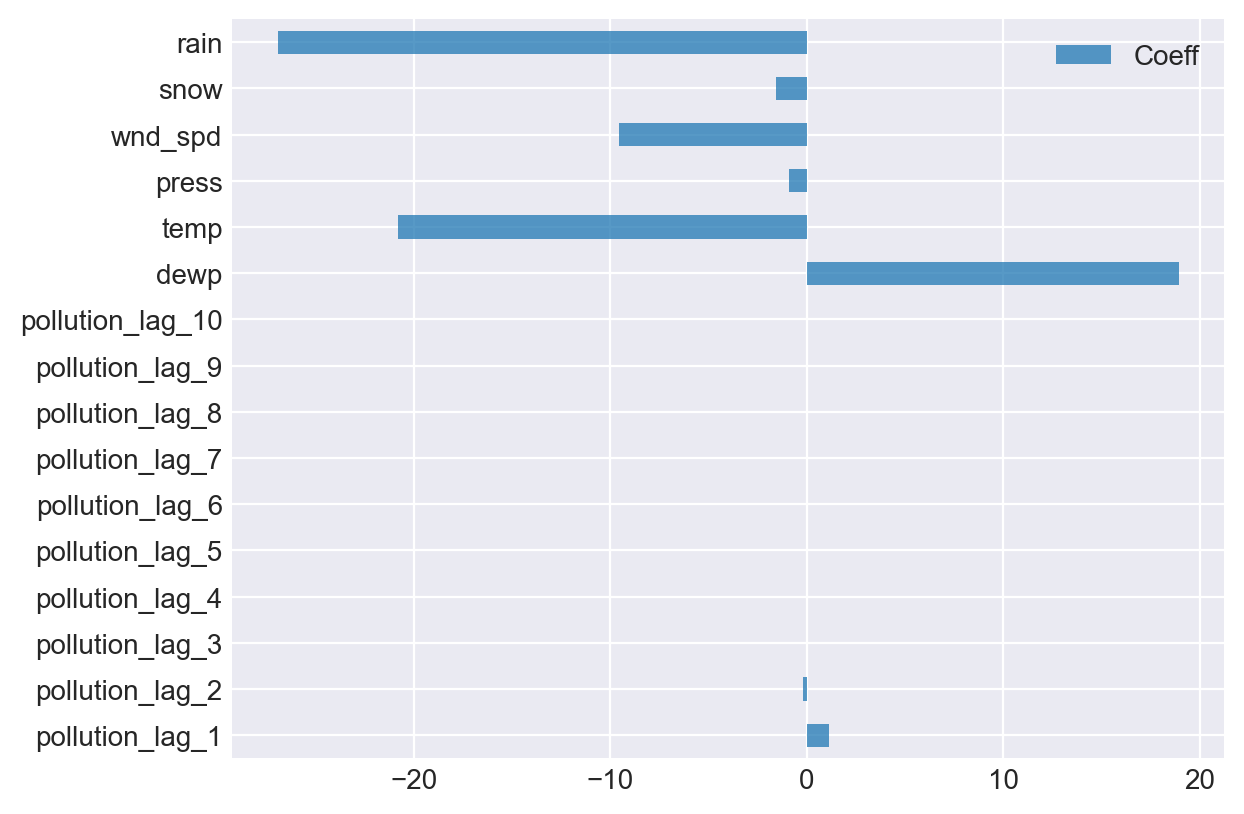

In [18]:
pd.DataFrame(model_coeff, index=model_fname_in, columns=["Coeff"]).plot(
    kind="barh", alpha=0.75
)